# Adaptive anisotropic stochastic collocation for a heat transfer PDE

This MATLAB notebook shows one possible way of solving a partial differential equation (PDE) with random parameters. The discretization in space and time is done with **triangular finite elements** and a **MATLAB ODE solver** for stiff problems, respectively. The random part is discretized by means of an interpolation with adaptive, anisotropic placement of nodes on a **sparse grid**.

To minimize the interpolating nodes is especially important, because each node means solving a deterministic PDE, which is computationally demanding in many cases. Although the task is very well parallelizable, one needs to break the **curse of dimensionality**.

The notebook contains sections about the following topics:

* **Deterministic preprocessing**: mesh and ODE settings
* **Random preprocessing**: parametrization of a random field
* Settings and running of anisotropic adaptive **stochastic collocation**
* **Deterministic postprocessing**: space and time integration or evaluation in fixed points
* **Random postprocessing**: getting the mean, variance, and density of the numerical results

<img src="domain.png" width="500"/>

\begin{equation}
\begin{aligned}
 \partial_t T -\nabla\cdot (\alpha({\textbf x},\omega)\nabla T) &= 0 & \text{ in } D\times(0,1]\times\Omega \ \\
 -\alpha({\textbf x},\omega)\ \nabla T\cdot \mathbf n &= 0 &\text{ in } \partial D_1\times(0,1]\times\Omega \ \\
 -\alpha({\textbf x},\omega)\ \nabla T\cdot \mathbf n &= -1 &\text{ in } \partial D_2\times(0,1]\times\Omega \ \\
 T({\textbf x},0,\omega) &= 0 &\text{ in } D\times\Omega
\end{aligned}
\end{equation}

The problem describes the heat conduction in an electronic chip with the uncertain heat conductivity $\alpha$, modeled as a random field, discretized by means of a truncated Karhunen-Loève expansion with 3 uniformly distributed random variables. The figure shows the two-dimensional spatial domain $D$ of the chip. At the cavity a heat flux into the domain is assumed; the remaining boundary is assumed to be adiabatic and the initial temperature is set to 0. The governing equation is the unsteady heat equation subject to the boundary conditions just described, with temperature $T$, sample space $\Omega$, a sample $\omega$, time interval $(0,1]$, spatial points $\textbf x$, and $\mathbf n$ denotes the outer normal vector with respect to $D$. Adaptive anisotropic stochastic collocation on a sparse grid is applied to discretize the random space efficiently.

In [1]:
% add functions to path
addpath(genpath('functions'));

In [2]:
% Solution folder settings to avoid keeping all results in RAM and to store intermediate results
problemfolder = '.'; % name of the path, where the solution folder is placed
solutionfolder = [problemfolder,'/solutions'];
% generate the folder if it doesn't exist
if ~exist(solutionfolder,'file')
    mkdir(solutionfolder);
end

# Preprocessing I: spatial grid / mesh

In [3]:
% parameters
refinementlevel = 3;

In [4]:
sol = readSol(2,1,'finiteElementMesh.geo'); % read coarse grid
points = sol.points(2:3,:)'; % extract the points
cells = sol.triangles(2:4,:)'+1; % extract the triangles

In [5]:
% refine coarse mesh until specified refinement level is reached
for i = 1:refinementlevel
    [points,cells,~,I] = RefineTriangularGrid(points,cells);
end
mesh = LinearTriangularMesh(points,cells); % construct a mesh with various information

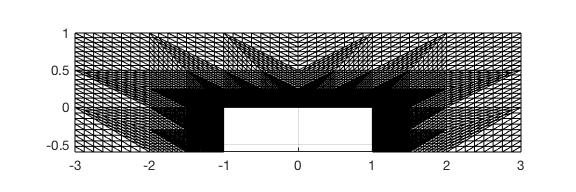

In [6]:
% plot the mesh and see the computational domain
trimesh(cells,points(:,1),points(:,2),points(:,1),'EdgeColor','black');
view(2)
axis equal tight
set(gcf, 'PaperPosition', [0 0 6 2])

## Preprocessing II: random space / Karhunen-Loève expansion

The conductivity parameter $\alpha$ is the source of uncertainty, and is modelled as a spatially correlated random field with expected value $E[\alpha]=1$, correlation length $L=4$, and standard deviation $\sigma=0.2$. More precisely, we use the covariance function 

\begin{equation}
 C_{\alpha}(\textbf x,\tilde{\textbf x} )=\sigma^2\frac{\|\textbf x-\tilde{\textbf x}\|_2}{L}K_1\left(\frac{\|\textbf x-\tilde{\textbf x}\|_2}{L}\right),
\end{equation}

where $K_1$ refers to the modified Bessel function of second kind and first order. This kind of covariance function is commonly used in statistics and very
suitable for two-dimensional random fields. It belongs to the family of Matérn covariance functions. We obtain the covariance spectrum numerically on the same
spatial discretization as used for the calculations with linear finite element ansatz functions and $3$-point quadrature rules to approximate the discrete
covariance matrix. The choice of covariance function leads to three terms to be used in the truncated Karhunen-Loève
expansion of $\alpha$, and are chosen to be uniformly distributed. The figure some cells below shows the first three eigenfunctions.

In [7]:
% parameters
L = 4; % correlation length
sigma = 0.2; % standard deviation

In [8]:
% store eigenvalues and eigenvectors to construct them only once 
% for each correlation length and refinement level
eigInfoName = ['eigInfoL',int2str(L),'refine',int2str(refinementlevel),'.mat'];
if ~exist(eigInfoName,'file')
    % run the eigenvalue compuation by means of a Galerkin approach (on the same meth
    [V,lambda] = GalerkinEigenProblem2(L,points,cells,'full');
    save(eigInfoName,'V','lambda');
else
    load(eigInfoName,'V','lambda'); % load KL data
end

% dimension of random space (number of eigenvalues which explain at least 95% of variance
if length(lambda) < size(points,1) % in case lambda had been truncated before
    d = length(lambda);
else
    d = find(cumsum(lambda)/sum(lambda)>0.95,1,'first');
    lambda = lambda(1:d);
    V = V(:,1:d);
end

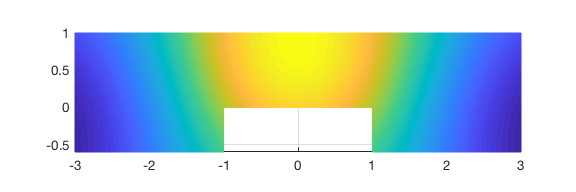

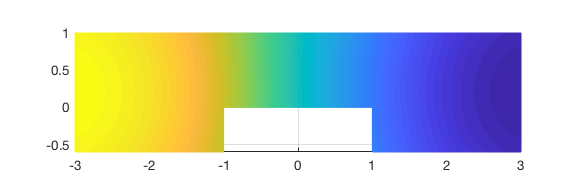

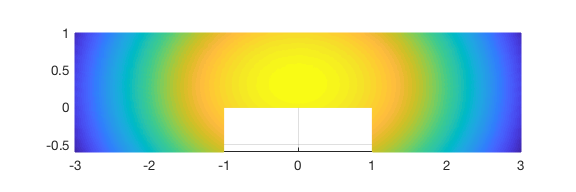

In [9]:
% plot the most important eigenfunctions of the covariance kernel
for i = 1:d
    figure
    trimesh(cells,points(:,1),points(:,2),V(:,i),'FaceColor','interp','EdgeColor','interp');
    view(2)
    axis equal tight
    set(gcf, 'PaperPosition', [0 0 6 2])
end

In [10]:
% multiply the eigenvectors with the square root of the eigenvalues
% to take into account that the standard deviation differs from 1
V = bsxfun(@times,V,sigma*sqrt(lambda'));

# Time evolution: settings for semi-discrete ODE

In [11]:
% parameters
transformationFunc = @(x)[ones(size(x,1),1) x]; % simple transformation needed for the simulation
tspan = [0 1]; % time horizon
type = 2; % type = 1 for steady state problem, type = 2 for time stepping
odeSolver = @ode15s; % MATLAB ODE solver for stiff problems
odeOptions = odeset('RelTol',1e-5, 'AbsTol',1e-5); % tolerances

In [12]:
% generate object for the problem under consideration, 
% which performs the actual time stepping for each realization of
% the random space
heatObj = HeatClass(mesh,[ones(mesh.nPoints,1) V],transformationFunc,tspan,odeSolver,odeOptions,type);

# Stochastic collocation: random space discretization

We apply a tolerance of $1.0e-3$ to stochastic collocation and use Gauss-Patterson-Legendre collocation points.

In [13]:
% cell array of function handles for the quantities of interest (QoI).
% The adaptive placing of points proceeds with resprect to the QoI that is explicitly specified.
qoiHandles = {@(x)qoiSpaceTimeIntegral(x,heatObj.mesh,heatObj.freeNodes);
    @(x)qoiTimeIntegral(x,heatObj.mesh,heatObj.freeNodes,0,0);
    @(x)qoiSpaceIntegral(x,heatObj.mesh,heatObj.freeNodes);
    @(x)qoiMaxValue(x,heatObj.mesh,heatObj.freeNodes,0,0);
    @(x)qoiMaxValue(x,heatObj.mesh,heatObj.freeNodes,0,0.5);
    @(x)qoiMaxValue(x,heatObj.mesh,heatObj.freeNodes,1,0.5);
    @(x)qoiMaxValue(x,heatObj.mesh,heatObj.freeNodes,2,0.5);
    @(x)qoiMaxValue(x,heatObj.mesh,heatObj.freeNodes,2,0);
    @(x)qoiMaxValue(x,heatObj.mesh,heatObj.freeNodes,1,-0.6)};

Define all settings to build up the interpolating function **func** in d dimensions on **[a,b]^d**
using maximal level **slevel**. 

The generalized Smolyak algorithm is used with 
global hierarchical Lagrange polynomials as basis functions.

**rule** = string to determine the quadrature nodes which form the grid

**func** string to determine the underlying functions which needs to be evaluated in the nodes

**tol** = tolerance for the global error indicator

**omega** = balancing number between 0 and 1 (the higher the stronger anisotropic)

In [14]:
% boundaries of the uniformly distributed random variable with zero mean and unit variance
a = -sqrt(3);
b = sqrt(3);
slevel = 6;
tol = 1.0e-3;
omega = 0.5;
maxcounter = 100;
qoi = 2; % Spcify which QoI from qoiHandles is actually used: time integral in the most active part of the domain
rule = {'GaussPattersonLegendre',ones(1,d)};
func = @(nodes,problemfolder)parabolic2D(nodes,problemfolder,@(x)heatObj.compute(x),qoiHandles);

## Here comes the main part: run adaptive stochastic collocation on a sparse grid

**Each collocation point means running a deterministic PDE (in space and time, prepared by the heat object)**

In [16]:
[allnodes,level,surplus,intval,nodesol,alpha,deltagrid] = ...
    anisoHierLagrange(a,b,slevel,rule,d,func,tol,omega,problemfolder,maxcounter,qoi);

3
1.5
Anisotropic behaviour!
Global error indicator: 1.000000e+00
Largest local error indicator: 1.488764e-02
4
2
Anisotropic behaviour!
Global error indicator: 1.917724e-02
Largest local error indicator: 7.169717e-04
4
2.5
Anisotropic behaviour!
Global error indicator: 1.273717e-02
Largest local error indicator: 1.451947e-04
4
2.5
Anisotropic behaviour!
Global error indicator: 1.273717e-02
Largest local error indicator: 4.338248e-05
4
2.5
Anisotropic behaviour!
Global error indicator: 1.344571e-03
Largest local error indicator: 9.032822e-06
5
2.5
Anisotropic behaviour!
Global error indicator: 2.845666e-04
Largest local error indicator: 4.010045e-06
end of loop


# Postprocessing

For the presentation of the results, six reference points in the spatial domain $D$ are chosen, namely $(0,0)$, $(0,0.5)$, $(1,0.5)$, $(2,0.5)$, $(2,0)$, and
$(1,-0.6)$.

In [17]:
% parameters for plotting
t = tspan(1):0.02:tspan(2);

## Calculation of mean and variances

In [18]:
weights = intval'*alpha;
allmean = zeros(length(t),6);
allmean2 = allmean;
lastmean = 0;
lastmean2 = 0;
load([solutionfolder,'/nodelist']);
u = cell(6,1);
for i = 1:size(allnodes,1)
    [c,j] = tolismember(allnodes(i,:),nodelist(:,1:d),10^-8);
    if c
        I(i) = nodelist(j,end);
    end
    sol = load([solutionfolder,'/solution',int2str(I(i))]);
    
    u = zeros(mesh.nPoints,length(sol.x));
    u(heatObj.freeNodes,:) = sol.y;
    y1 = mesh.valueAt(0,0,u);
    y2 = mesh.valueAt(0,0.5,u);
    y3 = mesh.valueAt(1,0.5,u);
    y4 = mesh.valueAt(2,0.5,u);
    y5 = mesh.valueAt(2,0,u);
    y6 = mesh.valueAt(1,-0.6,u);
    lastmean = lastmean + weights(i)*u(:,end);
    lastmean2 = lastmean2 + weights(i)*u(:,end).^2;
    
    u = zeros(mesh.nPoints,size(sol.idata.dif3d,2)*size(sol.idata.dif3d,3));
    u(heatObj.freeNodes,:) = reshape(sol.idata.dif3d,size(sol.idata.dif3d,1),size(sol.idata.dif3d,2)*size(sol.idata.dif3d,3));
    
    sol.y = y1;
    sol.idata.dif3d = reshape(mesh.valueAt(0,0,u),1,size(sol.idata.dif3d,2),size(sol.idata.dif3d,3));
    allmean(:,1) = allmean(:,1)+ weights(i)*deval(t,sol)';
    allmean2(:,1) = allmean2(:,1)+ weights(i)*(deval(t,sol)').^2;
    
    sol.y = y2;
    sol.idata.dif3d = reshape(mesh.valueAt(0,0.5,u),1,size(sol.idata.dif3d,2),size(sol.idata.dif3d,3));
    allmean(:,2) = allmean(:,2)+ weights(i)*deval(t,sol)';
    allmean2(:,2) = allmean2(:,2)+ weights(i)*(deval(t,sol)').^2;
    
    sol.y = y3;
    sol.idata.dif3d = reshape(mesh.valueAt(1,0.5,u),1,size(sol.idata.dif3d,2),size(sol.idata.dif3d,3));
    allmean(:,3) = allmean(:,3)+ weights(i)*deval(t,sol)';
    allmean2(:,3) = allmean2(:,3)+ weights(i)*(deval(t,sol)').^2;
    
    sol.y = y4;
    sol.idata.dif3d = reshape(mesh.valueAt(2,0.5,u),1,size(sol.idata.dif3d,2),size(sol.idata.dif3d,3));
    allmean(:,4) = allmean(:,4)+ weights(i)*deval(t,sol)';
    allmean2(:,4) = allmean2(:,4)+ weights(i)*(deval(t,sol)').^2;
    
    sol.y = y5;
    sol.idata.dif3d = reshape(mesh.valueAt(2,0,u),1,size(sol.idata.dif3d,2),size(sol.idata.dif3d,3));
    allmean(:,5) = allmean(:,5)+ weights(i)*deval(t,sol)';
    allmean2(:,5) = allmean2(:,5)+ weights(i)*(deval(t,sol)').^2;
    
    sol.y = y6;
    sol.idata.dif3d = reshape(mesh.valueAt(1,-0.6,u),1,size(sol.idata.dif3d,2),size(sol.idata.dif3d,3));
    allmean(:,6) = allmean(:,6)+ weights(i)*deval(t,sol)';
    allmean2(:,6) = allmean2(:,6)+ weights(i)*(deval(t,sol)').^2;
    
end

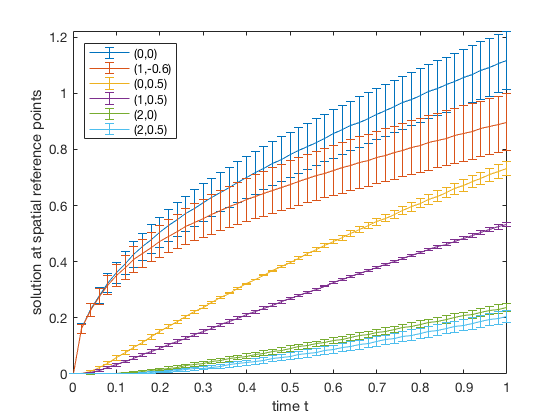

In [23]:
[~,I] = sort(allmean(end,:),'descend');
errorbar(repmat(t',1,6),allmean(:,I),sqrt(allmean2(:,I)-allmean(:,I).^2))
axis tight
xlabel('time t')
ylabel('solution at spatial reference points')
legendstr = {'(0,0)','(0,0.5)','(1,0.5)','(2,0.5)','(2,0)','(1,-0.6)'};
legendstr = legendstr(I);
legend(legendstr,'Location','NorthWest')

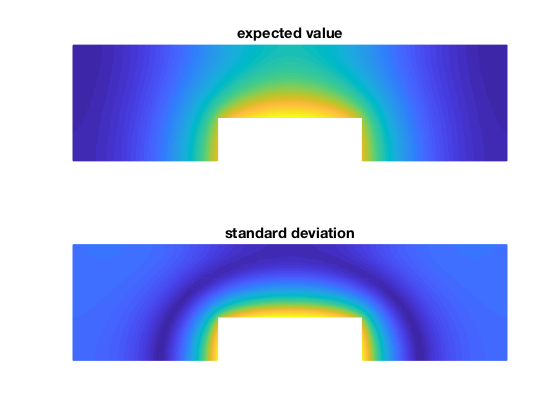

In [20]:
% plot expected value and variance at final point in time
subplot(2,1,1)
trimesh(cells,points(:,1),points(:,2),lastmean,'FaceColor','interp','EdgeColor','interp');
title('expected value')
CM = get(gcf,'Colormap');
view(2);axis equal tight off
subplot(2,1,2)
trimesh(cells,points(:,1),points(:,2),sqrt(lastmean2-lastmean.^2),'FaceColor','interp','EdgeColor','interp');
title('standard deviation')
colormap(CM);
view(2);axis equal tight off

In all plots we observe that there is more variance in the solution near the cavity. Moreover, the
time evolution reveals that the error bars seem to run into steady states. While the solution keeps growing, this is apparently not true for the variance.

## Plot random interpolating function together with collocation points in 2 dimensions

The figure below shows the full functional dependency of the Quantity of interest (time integral over most active point in the cavity) of the random variables image space projected on the first two random dimensions for illustration purposes. We see a slightly nonlinear behaviour especially in the dominating, first dimension. To resolve the first dimension adequately, the algorithm places more collocation points in this direction, which can be seen
in the plot as well. This example thus demonstrates nicely the anisotropic behaviour of the stochastic collocation procedure.

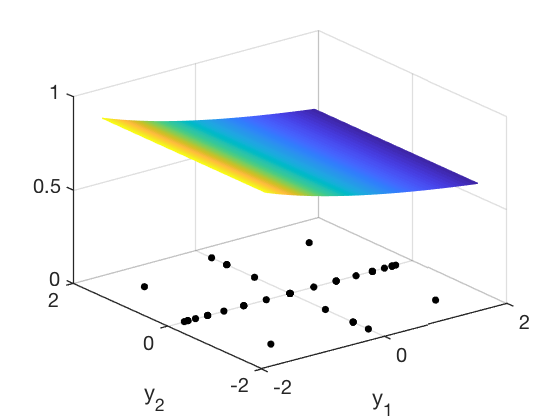

In [21]:
dimchecker = [1 2];
plotinterp([a a],[b b],allnodes,level,surplus{1}(:,qoi),[],'hier',dimchecker);
hold on
plot(allnodes(:,dimchecker(1)),allnodes(:,dimchecker(2)),'k.','MarkerSize',15)
set(gca,'FontSize',15,'LineWidth',1)
xlabel('y_1');
ylabel('y_2');

## Plot the density, approximated with Monte Carlo simulation

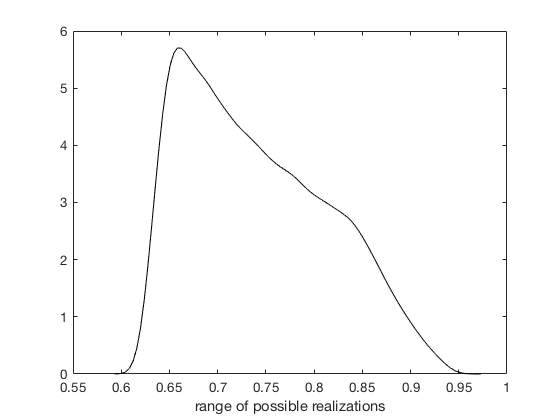

In [22]:
densX = rand(10^5,d)*(b-a)+a;
dens = plotinterp([],[],allnodes,level,surplus{1}(:,qoi),densX,'hier',[]);
[densdata,z] = ksdensity(dens,'function','pdf');
plot(z,densdata,'k');
xlabel('range of possible realizations')

We observe a quite long tail in the density to its right side. This shows that although uniformly distributed input is given, the output of the simulation will have its own probability distribution.